In [ ]:
# train = pd.read_pickle('../data/train_features1482_score_0.85605.pkl') 
# test = pd.read_pickle('../data/test_features1482_score_0.85605.pkl')

# train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
# test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')

# train = pd.read_pickle('../data/train_features1320_score_0.85577.pkl') 
# test = pd.read_pickle('../data/test_features1320_score_0.85577.pkl')

# train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
# test = pd.read_pickle('../data/test_features680_score_0.85558.pkl') 

# train = pd.read_pickle('../data/train_features397_score_0.85487.pkl') 
# test = pd.read_pickle('../data/test_features397_score_0.85487.pkl') 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

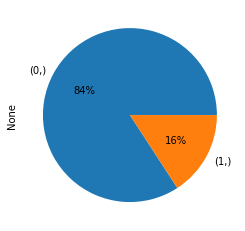

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Entrenando LGBM

In [4]:
train = pd.read_pickle('../data/train_features1628_score_0.85642.pkl') 
test = pd.read_pickle('../data/test_features1628_score_0.85642.pkl')
train.shape, test.shape

((358487, 1628), (396666, 1628))

In [5]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865934	training's binary_logloss: 0.284444	valid_1's auc: 0.851608	valid_1's binary_logloss: 0.296298
Early stopping, best iteration is:
[182]	training's auc: 0.878261	training's binary_logloss: 0.27438	valid_1's auc: 0.854401	valid_1's binary_logloss: 0.294017
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865794	training's binary_logloss: 0.284727	valid_1's auc: 0.851538	valid_1's binary_logloss: 0.296237
[200]	training's auc: 0.880394	training's binary_logloss: 0.27267	valid_1's auc: 0.854701	valid_1's binary_logloss: 0.293414
Early stopping, best iteration is:
[260]	training's auc: 0.887218	training's binary_logloss: 0.267118	valid_1's auc: 0.855368	valid_1's binary_logloss: 0.292908
********** 2 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865825	training's binar

In [9]:
fi.sort_values(ascending=False).head(50)

edad                                                 0.008045
ubigeo_mode                                          0.007883
sexo_0                                               0.005815
PRODUCTO_1_saldoMax_ult1meses                        0.005545
PRODUCTO_1_saldoMean_ult1meses                       0.005412
PRODUCTO_3_saldoUnique_ult12meses                    0.004899
estadocontribuyente_0                                0.004498
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.004368
PRODUCTO_1_saldoSum_ult1meses                        0.004280
PRODUCTO_6_saldoSum_ult12meses                       0.004146
PRODUCTO_1_saldoSum_ult2meses                        0.003999
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.003904
PRODUCTO_8_saldoUnique_ult12meses                    0.003786
cod_instit_financiera_34_saldoUnique_ult12meses      0.003680
RIESGO_DIRECTO_1_saldoStd_ult1meses                  0.003663
RIESGO_DIRECTO_1_saldoUnique_ult12meses              0.003588
PRODUCTO

In [10]:
fi.to_pickle('fi_lightgbm.pkl')

In [11]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Catboost con parametros casi estandar
### CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)

In [ ]:
train = pd.read_pickle('../data/test_features397_score_0.85487.pkl') 
test = pd.read_pickle('../data/test_features397_score_0.85487.pkl')
train.shape, test.shape

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6, random_state=42)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

In [ ]:
fi.to_pickle('fi_catboost.pkl')

In [ ]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## Entrenando LGBM categorical features

In [12]:
train = pd.read_pickle('../data/train_features1628_score_0.85642.pkl') 
test = pd.read_pickle('../data/test_features1628_score_0.85642.pkl')
train.shape, test.shape

((358487, 1628), (396666, 1628))

In [13]:
var_categ = [c for c in train.columns if 'mode' in c]
for c in var_categ:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.874774	training's binary_logloss: 0.278841	valid_1's auc: 0.849666	valid_1's binary_logloss: 0.297436
[200]	training's auc: 0.891884	training's binary_logloss: 0.264284	valid_1's auc: 0.852786	valid_1's binary_logloss: 0.295007
Early stopping, best iteration is:
[256]	training's auc: 0.899001	training's binary_logloss: 0.258099	valid_1's auc: 0.853492	valid_1's binary_logloss: 0.294456
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.875409	training's binary_logloss: 0.278477	valid_1's auc: 0.848777	valid_1's binary_logloss: 0.297798
Early stopping, best iteration is:
[153]	training's auc: 0.88526	training's binary_logloss: 0.269949	valid_1's auc: 0.85071	valid_1's binary_logloss: 0.296028
********** 2 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.875302	training's binary_logloss: 0.27891	valid

In [18]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.110613
ubigeo_mode                                          0.043196
cod_instit_financiera_mode_ult1mes                   0.038008
cod_instit_financiera_mode_ult12mes                  0.024070
cod_instit_financiera_mode_ult2mes                   0.019504
cod_instit_financiera_mode_ult3mes                   0.015388
cod_instit_financiera_mode_ult11mes                  0.014324
cod_instit_financiera_mode_ult10mes                  0.013508
cod_instit_financiera_mode_ult4mes                   0.013092
cod_instit_financiera_mode_ult5mes                   0.012874
cod_instit_financiera_mode_ult8mes                   0.012436
cod_instit_financiera_mode_ult7mes                   0.011420
cod_instit_financiera_mode_ult6mes                   0.009407
edad                                                 0.007173
sexo_0                                               0.005515
PRODUCTO_1_saldoMean_ult1meses                       0.004864
codzona_

In [19]:
fi.to_pickle('fi_lightgbm_cf.pkl')

In [20]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm_cf.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm_cf.pkl')

## Entrenando GradientBosstingClassifier

In [42]:
path = '../data'
train = pd.read_pickle(f'{path}/train_features397_score_0.85487.pkl') 
test = pd.read_pickle(f'{path}/test_features397_score_0.85487.pkl')
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')
train.shape, test.shape

((358487, 397), (396666, 397))

In [43]:
var_categ = [i for i in train.columns if 'mode' in i]
var_cuanti = [i for i in train.columns if 'mode' not in i]
for i in var_cuanti:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(train[i].median())    
for i in var_categ:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0]) 

In [ ]:
def get_roc_auc_gbc(idx):
    dict_result = {}
    estimator = GradientBoostingClassifier(n_estimators=30, learning_rate=0.3, subsample=0.8,
                                             max_depth=5, verbose=10, max_features=0.82, random_state=42,
                                             n_iter_no_change = 10, tol=0.01)    
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    estimator.fit(Xt, yt)   
    train_score = roc_auc_score(yt, estimator.predict_proba(Xt)[:,-1])
    val_score = roc_auc_score(yv, estimator.predict_proba(Xv)[:,-1])
    train_probs = pd.Series(estimator.predict_proba(Xv)[:,-1], index = Xv.index)
    test_probs = pd.Series(estimator.predict_proba(test)[:,-1], index = test.index)

    dict_result['train_score'] = train_score
    dict_result['val_score'] = val_score
    dict_result['train_probs'] = train_probs
    dict_result['test_probs'] = test_probs
    
    return dict_result

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from multiprocessing.dummy import Pool
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
pool = Pool(10)
folds = [train.index[t] for t, v in KFold(5).split(train)]
dict_result_list = []
for dict_result in pool.map(get_roc_auc_gbc, folds):
    print(dict_result)
    dict_result_list.append(dict_result)
    
# np.save('dict_result_list_gbc.npy', dict_result_list) 
train_probs = [] 
test_probs = [] 
train_score = []
val_score = []
for dict_result in dict_result_list:
    train_probs.append(dict_result['train_probs'])
    test_probs.append(dict_result['test_probs'])
    train_score.append(dict_result['train_score'])
    val_score.append(dict_result['val_score'])
train_score = np.mean(train_score)
val_score = np.mean(val_score)

train_probs_gbc = pd.concat(train_probs)
test_probs_gbc = pd.concat(test_probs,axis=1).mean(axis=1)
train_score, val_score

In [44]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                         max_depth=5, verbose=1, max_features=0.82, random_state=42,
                                         n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)
   
    learner.fit(Xt, yt)        
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
    print('roc_auc_estimado de : ' + str(roc_auc_score(yv, pd.Series(learner.predict_proba(Xv)[:, -1]))))    
        
test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7709           0.0972          105.06m
         2           0.7287           0.0412          101.81m
         3           0.6979           0.0271          105.22m
         4           0.6868           0.0130          107.73m
         5           0.6731           0.0140          108.31m
         6           0.6611           0.0096          107.73m
         7           0.6527           0.0063          105.82m
         8           0.6502           0.0049          104.75m
         9           0.6447           0.0057          104.28m
        10           0.6371           0.0043          104.27m
        20           0.6095           0.0008          102.20m
roc_auc_estimado de : 0.834755336881636
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7700           0.1051          104.37m
         2           0.7244           0.04

KeyboardInterrupt: 

In [16]:
fi.to_pickle('fi_gbc.pkl')

In [21]:
train_probs_gbc = train_probs
test_probs_gbc = test_probs
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')